In [ ]:
# First step - connect to my github and clone the repo!
!git clone https://github.com/eron93br/football-and-baseball.git

Cloning into 'football-and-baseball'...
remote: Enumerating objects: 1510, done.
remote: Total 1510 (delta 0), reused 0 (delta 0), pack-reused 1510
Receiving objects: 100% (1510/1510), 454.32 MiB | 36.50 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Checking out files: 100% (1510/1510), done.


## The Dataset 

The dataset used in this project was constructed following the methodology described below:

###**Football Images**

Using the notebook ```Wikipedia - Get Players Name.ipynb``` , I got the names of the best players from NFL (seasons 2011-2021). After getting the names, I filterd for unique players (since a player can appear in two different years)

After that I can use either the script ```downloader.py``` or ```scrapper.py``` to make the images download. 

Note that I've run these scripts locally in Machine, since I need the Selenium webdriver. 

####**Baseball Images**

Using the built webscrapper I got images from best MLB players. 

- Pictures with ```100xxx.jpg``` and ```200yyy.jpg``` are related to **Footbal** players images. 

- Pictures with ```300xxx.jpg``` are related to **Baseball** players images. 
- Pictures with ```400xxx.jpg``` are related to **Hockey** players images.


The total database contains

- Football players  ```609 images```
- Baseball players  ```316 images```
- Hockey players  ```581 images```

![img1](https://iili.io/lRJNGp.png)

To run this notebook, please download the content from my Github and train the model. If you prefer, you can load the models using the files located in ```/models``` folder. 

You can load the model using 

```
  model.load_state_dict(torch.load(PATH))
  the_model = torch.load(PATH)
```

## Loading the dataset

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy

In [ ]:
# Some prints to make easy our debug
print(torch.__version__)
print(torch.cuda.is_available())

1.10.0+cu111
False


### Define Image Transfomers

In [ ]:
# At this time, we gonna ignore hockey images, in order to do so...
! rm -rf football-and-baseball/train/hock/
! rm -rf football-and-baseball/val/hock/

In [ ]:
# Make transforms and use data loaders

# We'll use these a lot, so make them variables
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

chosen_transforms = {'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]),
}

In [ ]:
# Set the directory for the data
data_dir = 'football-and-baseball/'

# Use the image folder function to create datasets
chosen_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), chosen_transforms[x]) for x in ['train', 'val']}

In [ ]:
chosen_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 1053
     Root location: football-and-baseball/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(256, 256), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
                RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'val': Dataset ImageFolder
     Number of datapoints: 453
     Root location: football-and-baseball/val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [ ]:
# Create Data Loaders
dataloaders = {x: torch.utils.data.DataLoader(chosen_datasets[x], batch_size=4, shuffle=True, num_workers=4)for x in ['train', 'val']}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f5119d11790>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f5119d11890>}

In [ ]:
# Split dataloaders in two different objects
trainloader = dataloaders['train']
testloader = dataloaders['val']

In [ ]:
dataset_sizes = {x: len(chosen_datasets[x]) for x in ['train', 'val']}
class_names = chosen_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
dataset_sizes

{'train': 647, 'val': 278}

In [ ]:
print(dataset_sizes)
print(class_names)

{'train': 647, 'val': 278}
['base', 'foot']


In [ ]:
# Visualize some images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


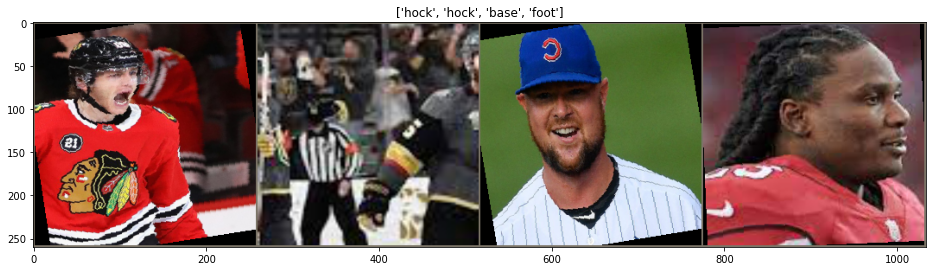

In [ ]:
from matplotlib.pyplot import figure

# Grab some of the training data to visualize
inputs, classes = next(iter(dataloaders['train']))

# Now we construct a grid from batch
out = torchvision.utils.make_grid(inputs)

figure(figsize=(16, 10))
imshow(out, title=[class_names[x] for x in classes])

### Base Model (1) - Using Resnet34 

In [ ]:
# Setting up the model
# load in pretrained and reset final fully connected

res_mod = models.resnet34(pretrained=True)

num_ftrs = res_mod.fc.in_features
res_mod.fc = nn.Linear(num_ftrs, 2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
for name, child in res_mod.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [ ]:
# 1 - 
res_mod = res_mod.to(device)

# 2 - Define our loss function
criterion = nn.CrossEntropyLoss()

# 3 - Optmization - Observe that all parameters are being optimized
optimizer_ft = optim.SGD(res_mod.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
exp_lr_scheduler

## Defining Train Model Method

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    list_train_loss = [] 
    list_train_acc = [] 
    list_val_loss = []
    list_val_acc = []
    #
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                # Set model to training mode
                model.train()  
            else:
                # Set model to evaluate mode
                model.eval()  

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            #register to output lists
            if phase == 'train':
              list_train_loss.append(epoch_loss)
              list_train_acc.append(epoch_acc)
            if phase == 'val':
              list_val_loss.append(epoch_loss)
              list_val_acc.append(epoch_acc)

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        # Variables to be written on tensorboard!
        #writer.add_scalar('Loss/train', epoch_loss/len(trainloader), epoch)

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model, list_train_loss, list_train_acc, list_val_loss, list_val_acc

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Train Resnet Model 1 - For 10 epochs

In [ ]:
base_model, train_loss, train_acc, val_loss, val_acc = train_model(res_mod, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
Iterating through data...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.5034 Acc: 0.7713
Iterating through data...
val Loss: 0.1440 Acc: 0.9460

Epoch 1/9
----------
Iterating through data...
train Loss: 0.4915 Acc: 0.8269
Iterating through data...
val Loss: 0.1830 Acc: 0.9496

Epoch 2/9
----------
Iterating through data...
train Loss: 0.4327 Acc: 0.8253
Iterating through data...
val Loss: 0.0784 Acc: 0.9748

Epoch 3/9
----------
Iterating through data...
train Loss: 0.3451 Acc: 0.8810
Iterating through data...
val Loss: 0.1298 Acc: 0.9532

Epoch 4/9
----------
Iterating through data...
train Loss: 0.3500 Acc: 0.8841
Iterating through data...
val Loss: 0.1209 Acc: 0.9532

Epoch 5/9
----------
Iterating through data...
train Loss: 0.3158 Acc: 0.8872
Iterating through data...
val Loss: 0.0698 Acc: 0.9640

Epoch 6/9
----------
Iterating through data...
train Loss: 0.2382 Acc: 0.9212
Iterating through data...
val Loss: 0.0788 Acc: 0.9640

Epoch 7/9
----------
Iterating through data...
train Loss: 0.2628 Acc: 0.9119
Iterating through data...
val L

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


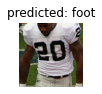

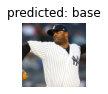

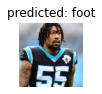

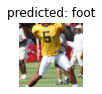

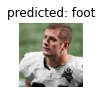

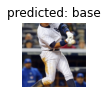

In [ ]:
visualize_model(base_model)
plt.show()

### Learning Curve

In [ ]:
# train_loss, train_acc, val_loss, val_acc
v_epoch = list(range(1,11))

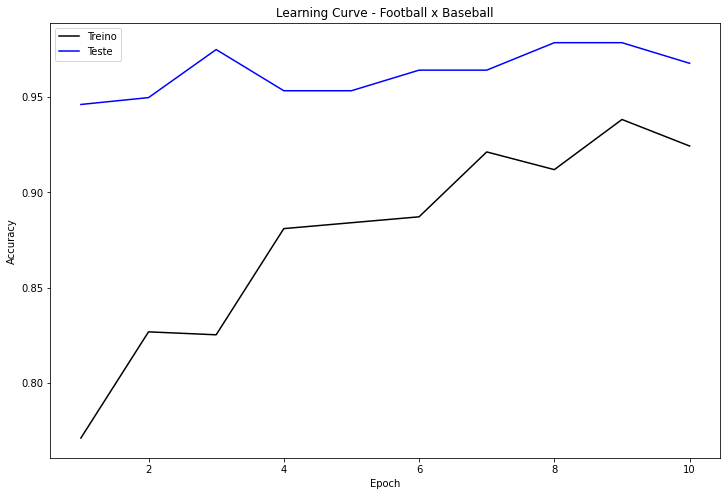

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(v_epoch, train_acc, 'k', label='Treino')
plt.plot(v_epoch, val_acc, 'b', label='Teste')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Learning Curve - Football x Baseball')
plt.legend()

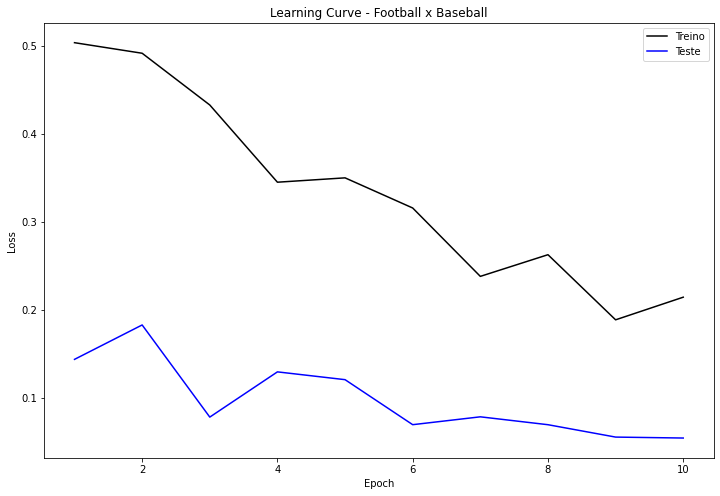

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(v_epoch, train_loss, 'k', label='Treino')
plt.plot(v_epoch, val_loss, 'b', label='Teste')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve - Football x Baseball')
plt.legend()

### Save Base Model

In [ ]:
# torch.save(the_model, PATH)
# the_model = torch.load(PATH)
torch.save(base_model, 'modelo4_epoch_10.pt')

## Train Resnet Model 1 - For 20 epochs

In [ ]:
base_model2, train_loss2, train_acc2, val_loss2, val_acc2 = train_model(res_mod, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
Iterating through data...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.2324 Acc: 0.9073
Iterating through data...
val Loss: 0.0566 Acc: 0.9748

Epoch 1/19
----------
Iterating through data...
train Loss: 0.1664 Acc: 0.9444
Iterating through data...
val Loss: 0.0586 Acc: 0.9748

Epoch 2/19
----------
Iterating through data...
train Loss: 0.2532 Acc: 0.9227
Iterating through data...
val Loss: 0.0703 Acc: 0.9712

Epoch 3/19
----------
Iterating through data...
train Loss: 0.1753 Acc: 0.9459
Iterating through data...
val Loss: 0.0624 Acc: 0.9712

Epoch 4/19
----------
Iterating through data...
train Loss: 0.1796 Acc: 0.9335
Iterating through data...
val Loss: 0.0632 Acc: 0.9748

Epoch 5/19
----------
Iterating through data...
train Loss: 0.1504 Acc: 0.9505
Iterating through data...
val Loss: 0.0806 Acc: 0.9712

Epoch 6/19
----------
Iterating through data...
train Loss: 0.1625 Acc: 0.9459
Iterating through data...
val Loss: 0.0614 Acc: 0.9748

Epoch 7/19
----------
Iterating through data...
train Loss: 0.2483 Acc: 0.9057
Iterating through data..

### Save Base Model 

In [ ]:
# torch.save(the_model, PATH)
# the_model = torch.load(PATH)
torch.save(base_model2, 'modelo5_epoch_20.pt')

### Learning Curve

In [ ]:
ve2 = list(range(1,21))

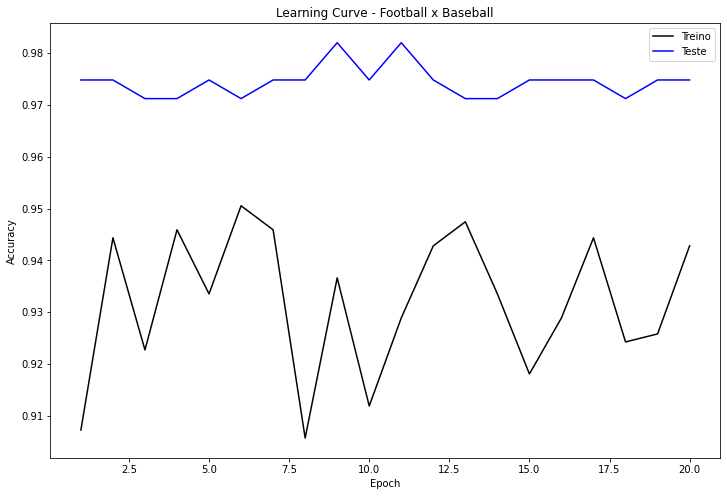

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(ve2, train_acc2, 'k', label='Treino')
plt.plot(ve2, val_acc2, 'b', label='Teste')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Learning Curve - Football x Baseball')
plt.legend()

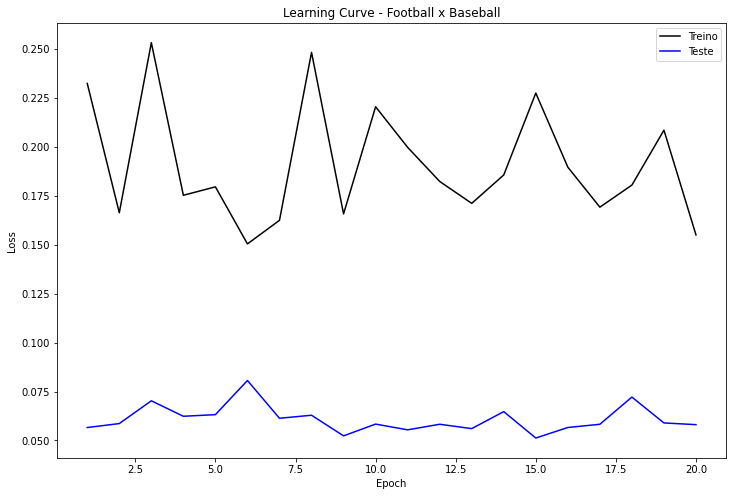

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(ve2, train_loss2, 'k', label='Treino')
plt.plot(ve2, val_loss2, 'b', label='Teste')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve - Football x Baseball')
plt.legend()

In [ ]:
# ------- Internal Routine -----------
# Download the specific Train / Validation (test) folders used in this routine
!zip -r /content/train.zip /content/football-and-baseball/train
!zip -r /content/val.zip /content/football-and-baseball/val

## Train Resnet Model 2 - classify three classes

At this time, let's evaluate the model for:

- Baseball 
- Football
- Hockey

images! :) 

In [ ]:
! rm -rf football-and-baseball/

In [ ]:
!git clone https://github.com/eron93br/football-and-baseball.git

Cloning into 'football-and-baseball'...
remote: Enumerating objects: 1510, done.
remote: Total 1510 (delta 0), reused 0 (delta 0), pack-reused 1510
Receiving objects: 100% (1510/1510), 454.32 MiB | 31.17 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Checking out files: 100% (1510/1510), done.


In [ ]:
# Make transforms and use data loaders

# We'll use these a lot, so make them variables
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

chosen_transforms = {'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]),
}

In [ ]:
# Set the directory for the data
data_dir = 'football-and-baseball/'

# Use the image folder function to create datasets
chosen_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), chosen_transforms[x]) for x in ['train', 'val']}

In [ ]:
chosen_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 1053
     Root location: football-and-baseball/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(256, 256), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
                RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'val': Dataset ImageFolder
     Number of datapoints: 453
     Root location: football-and-baseball/val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [ ]:
# Create Data Loaders
dataloaders = {x: torch.utils.data.DataLoader(chosen_datasets[x], batch_size=4, shuffle=True, num_workers=4)for x in ['train', 'val']}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
dataset_sizes = {x: len(chosen_datasets[x]) for x in ['train', 'val']}
class_names = chosen_datasets['train'].classes

In [ ]:
print(class_names)

['base', 'foot', 'hock']


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


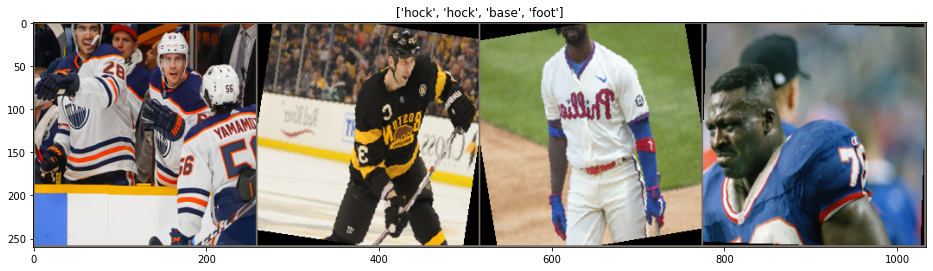

In [ ]:
from matplotlib.pyplot import figure

# Grab some of the training data to visualize
inputs, classes = next(iter(dataloaders['train']))

# Now we construct a grid from batch
out = torchvision.utils.make_grid(inputs)

figure(figsize=(16, 10))
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
# Setting up the model
# load in pretrained and reset final fully connected

res_mod = models.resnet34(pretrained=True)

num_ftrs = res_mod.fc.in_features
res_mod.fc = nn.Linear(num_ftrs, 3)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
dataset_sizes = {x: len(chosen_datasets[x]) for x in ['train', 'val']}
class_names = chosen_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(dataset_sizes)
print(class_names)

{'train': 1053, 'val': 453}
['base', 'foot', 'hock']


In [ ]:
# 1 - 
res_mod = res_mod.to(device)

# 2 - Define our loss function
criterion = nn.CrossEntropyLoss()

# 3 - Optmization - Observe that all parameters are being optimized
optimizer_ft = optim.SGD(res_mod.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
base_model, train_loss, train_acc, val_loss, val_acc = train_model(res_mod, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
Iterating through data...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.6961 Acc: 0.7094
Iterating through data...


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.2470 Acc: 0.9161

Epoch 1/19
----------
Iterating through data...
train Loss: 0.5249 Acc: 0.8053
Iterating through data...


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.1087 Acc: 0.9691

Epoch 2/19
----------
Iterating through data...
train Loss: 0.6094 Acc: 0.7863
Iterating through data...


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.1142 Acc: 0.9691

Epoch 3/19
----------
Iterating through data...
train Loss: 0.4944 Acc: 0.8234
Iterating through data...


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.1568 Acc: 0.9404

Epoch 4/19
----------
Iterating through data...
train Loss: 0.5163 Acc: 0.8015
Iterating through data...


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.2571 Acc: 0.8985

Epoch 5/19
----------
Iterating through data...
train Loss: 0.3987 Acc: 0.8547
Iterating through data...


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.2271 Acc: 0.9161

Epoch 6/19
----------
Iterating through data...
train Loss: 0.3022 Acc: 0.8974
Iterating through data...


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.0557 Acc: 0.9801

Epoch 7/19
----------
Iterating through data...
train Loss: 0.2920 Acc: 0.9012
Iterating through data...


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.0520 Acc: 0.9801

Epoch 8/19
----------
Iterating through data...
train Loss: 0.2715 Acc: 0.9003
Iterating through data...


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.0496 Acc: 0.9779

Epoch 9/19
----------
Iterating through data...
train Loss: 0.2712 Acc: 0.9079
Iterating through data...


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.0557 Acc: 0.9779

Epoch 10/19
----------
Iterating through data...
train Loss: 0.2227 Acc: 0.9269
Iterating through data...


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.0389 Acc: 0.9823

Epoch 11/19
----------
Iterating through data...
train Loss: 0.2291 Acc: 0.9174
Iterating through data...


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.0483 Acc: 0.9823

Epoch 12/19
----------
Iterating through data...
train Loss: 0.2030 Acc: 0.9307
Iterating through data...


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.0477 Acc: 0.9823

Epoch 13/19
----------
Iterating through data...
train Loss: 0.2370 Acc: 0.9202
Iterating through data...


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.0443 Acc: 0.9823

Epoch 14/19
----------
Iterating through data...
train Loss: 0.2442 Acc: 0.9155
Iterating through data...


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.0443 Acc: 0.9845

Epoch 15/19
----------
Iterating through data...
train Loss: 0.1964 Acc: 0.9307
Iterating through data...


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.0353 Acc: 0.9845

Epoch 16/19
----------
Iterating through data...
train Loss: 0.2266 Acc: 0.9174
Iterating through data...


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.0544 Acc: 0.9801

Epoch 17/19
----------
Iterating through data...
train Loss: 0.1920 Acc: 0.9259
Iterating through data...


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.0396 Acc: 0.9868

Epoch 18/19
----------
Iterating through data...
train Loss: 0.2078 Acc: 0.9335
Iterating through data...


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.0347 Acc: 0.9912

Epoch 19/19
----------
Iterating through data...
train Loss: 0.2246 Acc: 0.9221
Iterating through data...


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


val Loss: 0.0389 Acc: 0.9868

Training complete in 238m 11s
Best val Acc: 0.991170


###  Learning Curve for Hockey,Baseball and Football model

In [ ]:
nbs  = list(range(1,21))

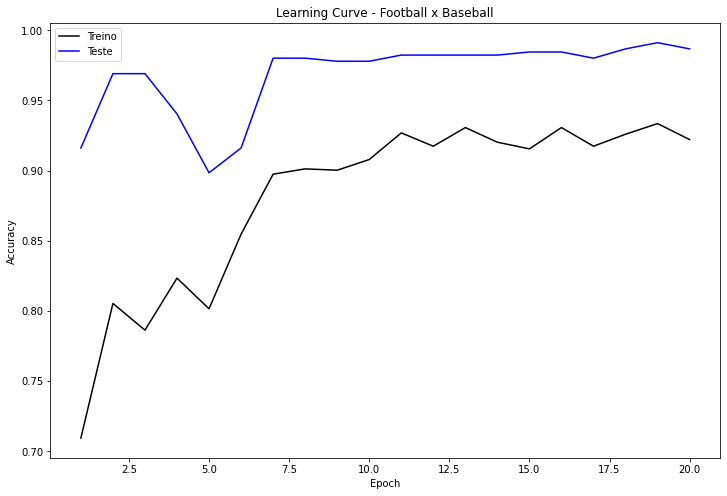

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(nbs, train_acc, 'k', label='Treino')
plt.plot(nbs, val_acc, 'b', label='Teste')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Learning Curve - Football x Baseball')
plt.legend()

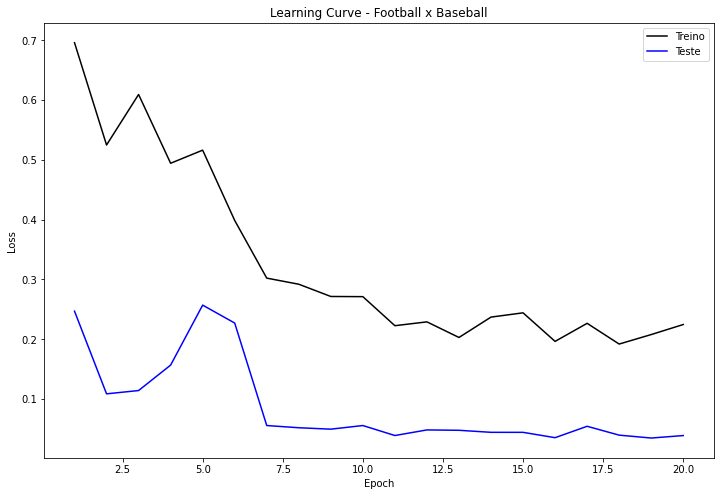

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(nbs, train_loss, 'k', label='Treino')
plt.plot(nbs, val_loss, 'b', label='Teste')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve - Football x Baseball')
plt.legend()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


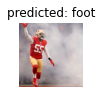

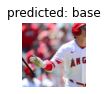

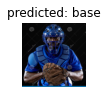

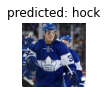

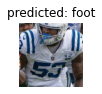

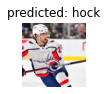

In [ ]:
visualize_model(base_model)
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


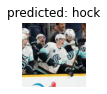

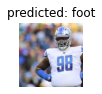

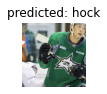

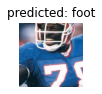

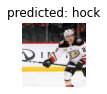

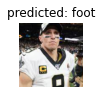

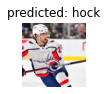

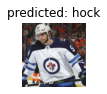

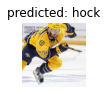

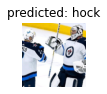

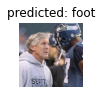

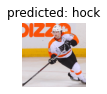

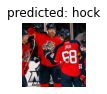

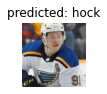

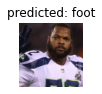

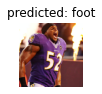

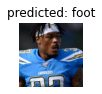

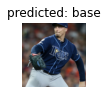

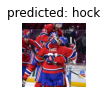

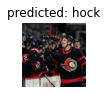

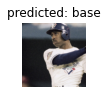

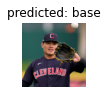

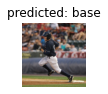

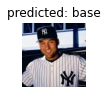

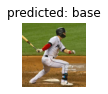

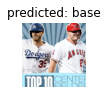

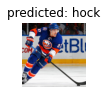

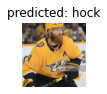

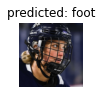

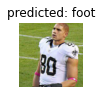

In [ ]:
for i in range(5):
  visualize_model(base_model)
  plt.show()

### Save Base Model

In [ ]:
torch.save(base_model, 'modelo2_hockey_ep20.pt')

## Conclusions

### Football x Baseball 

In a first moment the model is trained with 10 epochs. The observation at that time was that with more epochs the Learning Curve would converge (the loss for the validation and trainning groups). In a second attempt with 20 epochs, this is not accomplished. 

Thus, the best result was for 8 epochs (**```accuracy = 0.9784```** for validation set). 

From the results shown, I can affirm that the validation set is easier to be predicted than the trainning set. Maybe the images randomly selected contributes for this. 


### Football x Baseball x Hockey  (challenge)

Similarly for the football x baseball case, the classificator based on the three different sports classes get the best result on the 19th epoch. 
The accuracy obtained is **```0.9912```** a pretty good result. 

Differently from the previous classification (base x foot) we can see the Hockey dataset with more data thant the baseball players data. THis can explain a better global result, when compared the single comparision between footbal player x baseball player. 

All the results are obtained using a pre-treined resnet34 network. As a next step, I will compare custom networks and other pre-processing techniques to improve even further the accuracy result. 

Othe analysis can be done with a total balanced train/validation data groups. 
